# SVM Classification Using Individual Replicas
This notebook analyzes the quality of the classifiers resulting from training on individual replicas of read counts rather than averaged values. Data are adjusted for library size and gene length.

In [1]:
import init
from common import constants as cn
from common.trinary_data import TrinaryData
from common.data_provider import DataProvider
from common_python.plots import util_plots
from plots import util_plots as xutil_plots
from common_python.classifier import classifier_ensemble
from common_python.classifier import util_classifier
from common_python.classifier import classifier_collection
from common_python.classifier.classifier_ensemble_random_forest import ClassifierEnsembleRandomForest
from common_python.plots import util_plots as common_plots

import collections
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.model_selection import cross_val_score

%matplotlib inline

## Analyze Replica Data
The following shows the extent to which replicas agree with the tranary values that are assigned.

In [ ]:
def compareDFValues(df1, df2, title):
    RANGE = [-8, 8]
    plt.figure()
    arr1 = df1.values.flatten()
    arr2 = df2.values.flatten()
    plt.scatter(arr1, arr2)
    # Define region of 0 values
    plt.plot([-1, -1], [-1, 1], color="b")
    plt.plot([1, 1], [-1, 1], color="b")
    plt.plot([-1, 1], [-1, -1], color="b")
    plt.plot([-1, 1], [1, 1], color="b")
    # Define region of 1 values
    plt.plot([1, 1], [1, RANGE[1]], color="b")
    plt.plot([1, RANGE[1]], [1, 1], color="b")
    # Define region of -1 values
    plt.plot([-1, -1], [-1, RANGE[0]], color="b")
    plt.plot([-1, RANGE[0]], [-1, -1], color="b")
    plt.plot(RANGE, RANGE, color="r")
    plt.title(title)
    
provider = DataProvider()
provider.do()
dfs = []
for idx in range(3):
      dfs.append(provider.dfs_adjusted_read_count_wrtT0_log2[idx])
compareDFValues(dfs[0], dfs[1], "0 vs 1")
compareDFValues(dfs[0], dfs[2], "0 vs 2")
compareDFValues(dfs[1], dfs[2], "1 vs 2")
    

In [ ]:
dfs[0].values.flatten()


## Accuracy With Replicas
Compares accuracies with replicas (is_averaged=False) vs. with replicas as the data.

In [ ]:
def clfEval(is_averaged, high_rank=15, ensemble_size=50, is_randomize=False, num_iterations=10):
    trinary = TrinaryData(is_averaged=is_averaged, is_dropT1=is_averaged)
    df_X = trinary.df_X.copy()
    df_X.columns = trinary.features
    ser_y = trinary.ser_y.copy()
    if is_randomize:
        # Randomize the relationship between features and state
        df_X = df_X.sample(frac=1)
        ser_y = ser_y.sample(frac=1)
    #
    svm_ensemble = classifier_ensemble.ClassifierEnsemble(
        classifier_ensemble.ClassifierDescriptorSVM(), size=ensemble_size,
        filter_high_rank=high_rank)
    return classifier_ensemble.ClassifierEnsemble.crossValidateByState(
        svm_ensemble, df_X, ser_y, num_iterations)

In [ ]:
clfEval(True, ensemble_size=50, is_randomize=True)

In [ ]:
clfEval(False, ensemble_size=50, is_randomize=True)

In [ ]:
clfEval(True)

In [ ]:
clfEval(False)

## Analysis of Classifier Accuracy by State

In [ ]:
# Plot values by state
def plotValuesByState(states, values, stds=None, ylabel="percent"):
    if stds is None:
        plt.bar(states, values)
    else:
        plt.bar(states, values, yerr=stds, alpha=0.5)
    plt.xticks(rotation=45)
    plt.xlabel("state")
    plt.ylabel(ylabel)

In [ ]:
# State statistics
def plotStateDistributions():
    PERCENT = "percent"
    VALUE = "value"
    NAME = "name"
    trinary = TrinaryData(is_averaged=False, is_dropT1=False)
    df = pd.DataFrame(trinary.ser_y)
    df[VALUE] = list(np.repeat(1, len(df)))
    df_group = pd.DataFrame(df.groupby(NAME).count())
    dct = {v: k for k, v in trinary.state_dict.items()}
    df_group.index = [dct[s] for s in df_group.index]
    df_group[PERCENT] = 100*df_group[VALUE] / len(df)
    plotValuesByState(df_group.index, df_group[PERCENT])
    
plotStateDistributions()

In [ ]:
# Classification accuracy by state
def stateClassificationAccuracy(state, num_iterations=10, is_averaged=False):
    NUM_HOLDOUTS = 1
    is_dropT1 = is_averaged
    trinary = TrinaryData(is_averaged=is_averaged, is_dropT1=is_dropT1)
    df_X = trinary.df_X.copy()
    df_X.columns = trinary.features
    ser_y = trinary.ser_y
    results = []
    for _ in range(num_iterations):
        test_indices = []
        ser_sample = ser_y[ser_y == state].sample(n=NUM_HOLDOUTS)
        test_indices.extend(list(ser_sample.index))
        train_indices = list(set(df_X.index).difference(test_indices))
        svm_ensemble = classifier_ensemble.ClassifierEnsemble(
            classifier_ensemble.ClassifierDescriptorSVM(), size=30,
            filter_high_rank=1500,
            classes=list(ser_y.values))
        svm_ensemble.fit(df_X.loc[train_indices, :], ser_y.loc[train_indices])
        results.append(svm_ensemble.score(df_X.loc[test_indices, :], ser_y[test_indices]))
    return results

In [ ]:
def plotStateAccuracies(is_averaged=True):
    is_dropT1 = is_averaged
    trinary = TrinaryData(is_averaged=is_averaged, is_dropT1=is_dropT1)
    states = list(trinary.state_dict.values())
    avgs = []
    stds = []
    for state in states:
        values = stateClassificationAccuracy(state, is_averaged=is_averaged)
        avgs.append(np.mean(values))
        stds.append(np.std(values))
    plotValuesByState(list(trinary.state_dict.keys()), avgs, stds=stds, ylabel="accuracy")

In [ ]:
plotStateAccuracies(is_averaged=True)
plt.figure()
plotStateAccuracies(is_averaged=False)

In [ ]:
if False:
    is_averaged = False
    df = df_confuse.applymap(lambda v: np.nan if v <= 0.2 else 1)
    df.columns = [c - 0.5 for c in df.columns]
    trinary = TrinaryData(is_averaged=is_averaged, is_dropT1=is_averaged)
    states = trinary.ser_y.values
    state_colors = ["grey", "orange", "green", "pink", "peru", "greenyellow"]
    heatmap = plt.pcolor(df.T, cmap='jet')
    #fig = heatmap.get_figure()
    #axes = fig.get_axes()[0]
    #yaxis = axes.get_yaxis()
    #xv = [x + 0.5 for x in range(len(df.T.columns))]
    #yv = [y + 0.5 for y in range(len(df.T))]
    #plt.xticks(xv)
    #plt.yticks(yv)
    positions = [p - 0.5 for p in range(-1, len(states))]
    labels = [str(int(c-.5)) if c >= 0 else "" for c in positions]
    plt.yticks(positions, labels)
    for idx, state in enumerate(states):
        color = state_colors[state]
        plt.scatter(idx, [-1], color=color)
    #plt.colorbar(heatmap)


In [2]:
is_averaged = False
trinary = TrinaryData(is_averaged=is_averaged, is_dropT1=is_averaged)
svm_ensemble = classifier_ensemble.ClassifierEnsemble(
            classifier_ensemble.ClassifierDescriptorSVM(), size=50,
            filter_high_rank=15)
ser_pred = svm_ensemble.makeInstancePredictionDF(trinary.df_X, trinary.ser_y)

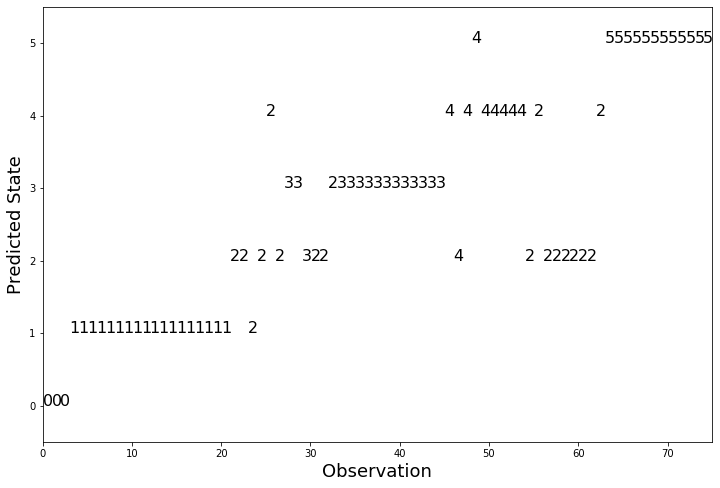

In [3]:
util_classifier.plotInstancePredictions(trinary.ser_y, ser_pred, is_plot=True)


In [ ]:
ser_pred.values

In [ ]:
trinary.ser_y.values